In [1]:
from collections import Counter
from src.dataset import load_benchmark_dataset, Species, Modification
from src.features.encodings import remove_central, dmf, binary

In [2]:
test_dataset = load_benchmark_dataset(Species.human, Modification.psi, True)
train_dataset = load_benchmark_dataset(Species.human, Modification.psi)

In [3]:
encoder = remove_central.Encoder()
dmf_encoder = dmf.Encoder()

In [18]:
def top_kmers(sequences: list[str], k: int, n: int) -> tuple[list, set]:
    kmer_counts = Counter()

    for sequence in sequences:
        for i in range(len(sequence) - k + 1):
            kmer = sequence[i:i + k]
            kmer_counts[kmer] += 1

    data = kmer_counts.most_common(n)
    return data, set(map(lambda x: x[0], data))


def analyze(p_train, n_train, p_test, n_test, k, n):
    pos_train = top_kmers(p_train, k, n)
    neg_train = top_kmers(n_train, k, n)
    pos_indep = top_kmers(p_test, k, n)
    neg_indep = top_kmers(n_test, k, n)
    pos_common = pos_train[1] & pos_indep[1]
    neg_common = neg_train[1] & neg_indep[1]

    print('+ive train', pos_train[0])
    print('-ive train', neg_train[0])
    print('+ive indep', pos_indep[0])
    print('-ive indep', neg_indep[0])
    print('-----------')
    print('+ive common', pos_common - neg_common)
    print('-ive common', neg_common - pos_common)

In [41]:
KMER_SIZE = 4
KMER_COUNT = 10

In [42]:
analyze(
    train_dataset.samples[train_dataset.targets == 1]['sequence'].values,
    train_dataset.samples[train_dataset.targets == 0]['sequence'].values,
    test_dataset.samples[test_dataset.targets == 1]['sequence'].values,
    test_dataset.samples[test_dataset.targets == 0]['sequence'].values,
    KMER_SIZE,
    KMER_COUNT,
)

+ive train [('UUUU', 158), ('CUUU', 102), ('UUUG', 88), ('AUUU', 82), ('UUUA', 78), ('UGUG', 69), ('UUCU', 67), ('UUUC', 67), ('UUAA', 66), ('UUCA', 62)]
-ive train [('UUUU', 190), ('AAAA', 96), ('AUUU', 85), ('UUUG', 85), ('UUCU', 75), ('UCUU', 72), ('CUUU', 71), ('UUGU', 71), ('UGUG', 71), ('UUUC', 70)]
+ive indep [('UUCU', 39), ('UAUC', 29), ('UUUU', 29), ('UGUU', 27), ('CUUU', 27), ('CUGU', 26), ('GUAU', 23), ('UUAU', 23), ('UCUG', 22), ('UCUU', 22)]
-ive indep [('UGUU', 28), ('CUCU', 26), ('UCUC', 23), ('UUUG', 22), ('GUUU', 21), ('UUGU', 20), ('UUAA', 19), ('UUUA', 19), ('UUUU', 18), ('CUUU', 17)]
-----------
+ive common {'UUCU'}
-ive common {'UUUG', 'UUGU'}


In [43]:
analyze(
    encoder.transform(
        train_dataset.samples[train_dataset.targets == 1]
    )['sequence_0'].values,
    encoder.transform(
        train_dataset.samples[train_dataset.targets == 0]
    )['sequence_0'].values,
    encoder.transform(
        test_dataset.samples[test_dataset.targets == 1]
    )['sequence_0'].values,
    encoder.transform(
        test_dataset.samples[test_dataset.targets == 0]
    )['sequence_0'].values,
    KMER_SIZE,
    KMER_COUNT,
)

+ive train [('UUUU', 106), ('AAAA', 70), ('CUUU', 67), ('UUUG', 61), ('UGGA', 60), ('GAAA', 60), ('UGUG', 59), ('AUUU', 59), ('AAAG', 59), ('AAGA', 58)]
-ive train [('UUUU', 139), ('AAAA', 110), ('AGAA', 73), ('GAAA', 67), ('AAAG', 67), ('AAGA', 66), ('GGAA', 64), ('UGGG', 63), ('AGGA', 62), ('AUUU', 62)]
+ive indep [('UUCU', 26), ('CUGU', 22), ('UCUU', 22), ('UCUC', 22), ('CCUU', 21), ('UUUU', 21), ('UCAA', 20), ('AAGU', 20), ('UGUA', 20), ('CUUU', 20)]
-ive indep [('UGUU', 21), ('AAAG', 18), ('UCCU', 17), ('UCUC', 17), ('AAAA', 17), ('CUCU', 16), ('UUAA', 16), ('UUCU', 15), ('AAAU', 15), ('CAGA', 15)]
-----------
+ive common {'UUUU', 'CUUU'}
-ive common {'AAAG', 'AAAA'}


In [46]:
def get_6_trids():
    nucle_com = []
    chars = ['A', 'C', 'G', 'U']
    base=len(chars)
    end=len(chars)**6
    for i in range(0,end):
        n=i
        ch0=chars[int(n%base)]
        n=n/base
        ch1=chars[int(n%base)]
        n=n/base
        ch2=chars[int(n%base)]
        n=n/base
        ch3=chars[int(n%base)]
        n=n/base
        ch4=chars[int(n%base)]
        n=n/base
        ch5=chars[int(n%base)]
        nucle_com.append(ch0 + ch1 + ch2 + ch3 + ch4 + ch5)
    return  nucle_com  

In [48]:
len(get_6_trids())

4096

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from src.features.encodings import remove_central, dmf, binary
import umap

import seaborn as sns

# Assume 'X' is your feature matrix and 'y' your labels

# 1. Feature engineering (example: adding GC content)
# def gc_content(seq):
#     return (seq.count('G') + seq.count('C')) / len(seq)
# 
# X['gc_content'] = X['sequence'].apply(gc_content)

# 2. Standardize features
scaler = StandardScaler()
encoder = binary.Encoder()
X_scaled = scaler.fit_transform(encoder.fit_transform(train_dataset.samples))
y = train_dataset.targets

ValueError: x must have 2 or fewer dimensions

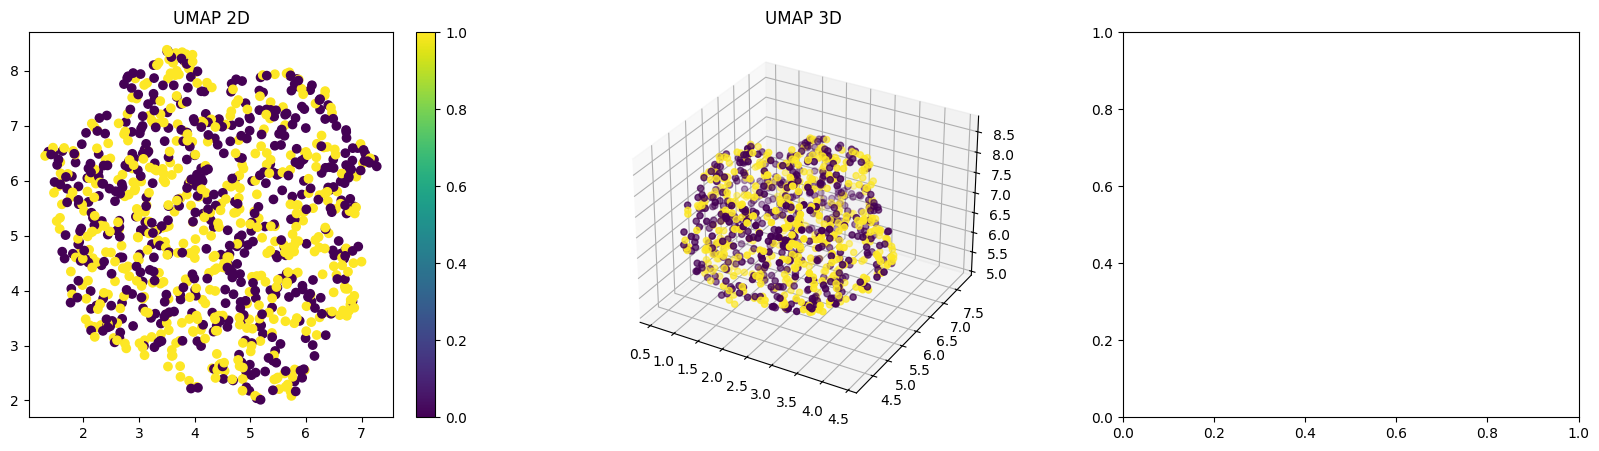

In [59]:
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_scaled)

# 4. UMAP with different parameters
umap_2d = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2)
umap_3d = umap.UMAP(n_neighbors=30, min_dist=0.05, n_components=3)

X_umap_2d = umap_2d.fit_transform(X_pca)
X_umap_3d = umap_3d.fit_transform(X_pca)

# 5. LDA
n_components = min(len(np.unique(y)) - 1, X_pca.shape[1])
lda = LinearDiscriminantAnalysis(n_components=n_components)
X_lda = lda.fit_transform(X_pca, y)

# Visualization
fig = plt.figure(figsize=(20, 5))

# UMAP 2D
ax = fig.add_subplot(131)
scatter = ax.scatter(X_umap_2d[:, 0], X_umap_2d[:, 1], c=y, cmap='viridis')
ax.set_title('UMAP 2D')
plt.colorbar(scatter)

# UMAP 3D
ax = fig.add_subplot(132, projection='3d')
scatter = ax.scatter(X_umap_3d[:, 0], X_umap_3d[:, 1], X_umap_3d[:, 2], c=y, cmap='viridis')
ax.set_title('UMAP 3D')

# LDA
ax = fig.add_subplot(133)
if X_lda.shape[1] >= 2:
    scatter = ax.scatter(X_lda[:, 0], X_lda[:, 1], c=y, cmap='viridis')
    ax.set_title('LDA')
    plt.colorbar(scatter)
else:
    ax.hist([X_lda[y==0]], label=['Class 0', 'Class 1'], bins=50)
    ax.legend()
    ax.set_title('LDA (1D Histogram)')

plt.tight_layout()
plt.show()

# Parallel Coordinates Plot
from pandas.plotting import parallel_coordinates

df = pd.DataFrame(X_pca[:, :10])
df['class'] = y
plt.figure(figsize=(12, 6))
parallel_coordinates(df, 'class')
plt.title('Parallel Coordinates Plot of PCA Components')
plt.show()

In [63]:
train_samples = train_dataset.samples
train_targets = train_dataset.targets.values
test_samples = test_dataset.samples
test_targets = test_dataset.targets.values

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6688 - val_loss: 0.5728
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5535 - val_loss: 0.5298
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5214 - val_loss: 0.5143
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5041 - val_loss: 0.4956
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4821 - val_loss: 0.4728
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4550 - val_loss: 0.4486
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4284 - val_loss: 0.4247
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3998 - val_loss: 0.4036
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3766 - val_loss: 0.3844
Epoch 10/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3588 - val_loss: 0.3687
Epoch 11/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3423 - val_loss: 0.3529
Epoch 12/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3220 - val_lo

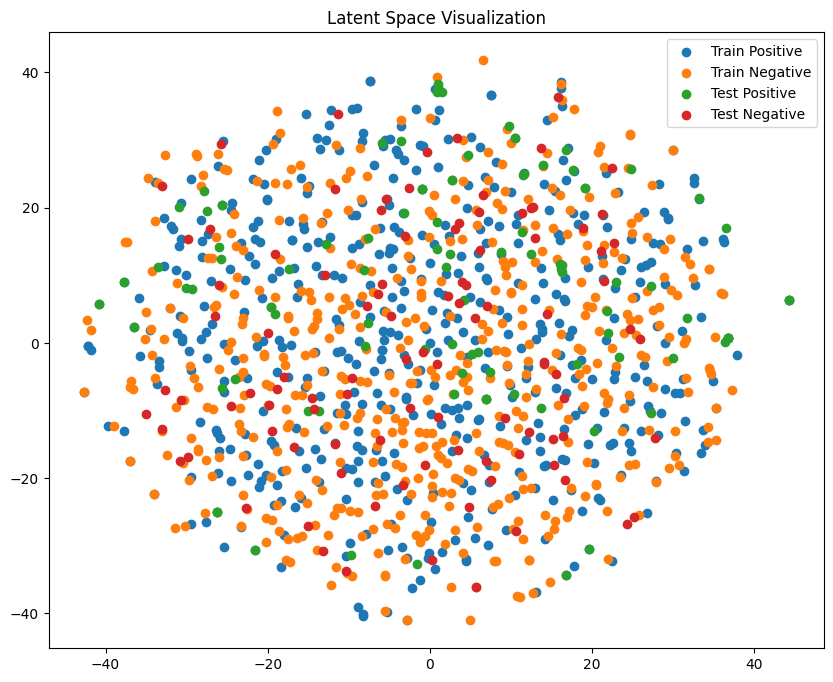

Cosine similarity between train positives and train negatives: 0.8630
Cosine similarity between test positives and test negatives: 0.8784
Cosine similarity between train positives and test positives: 0.8657
Cosine similarity between train positives and test positives: 0.8657
Cosine similarity between train negatives and test negatives: 0.8699
Intra-group similarity for train positives: 0.8645
Intra-group similarity for train negatives: 0.8623
Intra-group similarity for test positives: 0.8707
Intra-group similarity for test negatives: 0.8784


In [66]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from src.features.encodings import remove_central, dmf, pstnpss


# Assuming you have the following variables:
# train_samples, test_samples, train_targets, test_targets

# Step 1: Preprocess the data
def preprocess_sequences(sequences):
    # Convert sequences to numeric representation
    le = binary.Encoder()
    return le.fit_transform(sequences)
    # encoded_seqs = [le.fit_transform(list(seq)) for seq in sequences]
    # # Pad sequences to have the same length
    # max_length = max(len(seq) for seq in encoded_seqs)
    # padded_seqs = [np.pad(seq, (0, max_length - len(seq))) for seq in encoded_seqs]
    # return np.array(padded_seqs)

X_train = preprocess_sequences(train_samples)
X_test = preprocess_sequences(test_samples)

# Step 2: Build and train the autoencoder
input_dim = X_train.shape[1]
encoding_dim = 32  # Size of the latent space

input_layer = Input(shape=(input_dim,))
encoder = Dense(64, activation='relu')(input_layer)
encoder = Dense(encoding_dim, activation='relu')(encoder)
decoder = Dense(64, activation='relu')(encoder)
decoder = Dense(input_dim, activation='sigmoid')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)
encoder_model = Model(inputs=input_layer, outputs=encoder)

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, shuffle=True, validation_split=0.2)

# Step 3: Get latent representations
train_latent = encoder_model.predict(X_train)
test_latent = encoder_model.predict(X_test)

# Step 4: Separate positive and negative samples
train_pos = train_latent[train_targets == 1]
train_neg = train_latent[train_targets == 0]
test_pos = test_latent[test_targets == 1]
test_neg = test_latent[test_targets == 0]

# Step 5: Visualize using t-SNE
def plot_tsne(data_list, labels, title):
    tsne = TSNE(n_components=2, random_state=42)
    combined_data = np.vstack(data_list)
    tsne_results = tsne.fit_transform(combined_data)
    
    plt.figure(figsize=(10, 8))
    start = 0
    for i, data in enumerate(data_list):
        end = start + len(data)
        plt.scatter(tsne_results[start:end, 0], tsne_results[start:end, 1], label=labels[i])
        start = end
    
    plt.title(title)
    plt.legend()
    plt.show()

plot_tsne([train_pos, train_neg, test_pos, test_neg], 
          ['Train Positive', 'Train Negative', 'Test Positive', 'Test Negative'],
          'Latent Space Visualization')

# Step 6: Calculate cosine similarities
def calculate_cosine_similarity(group1, group2):
    return np.mean(cosine_similarity(group1, group2))

test_pos_test_neg_sim = calculate_cosine_similarity(test_neg, test_neg)
train_pos_train_neg_sim = calculate_cosine_similarity(train_pos, train_neg)
train_pos_test_pos_sim = calculate_cosine_similarity(train_pos, test_pos)
train_neg_test_neg_sim = calculate_cosine_similarity(train_neg, test_neg)

print(f"Cosine similarity between train positives and train negatives: {train_pos_train_neg_sim:.4f}")
print(f"Cosine similarity between test positives and test negatives: {test_pos_test_neg_sim:.4f}")
print(f"Cosine similarity between train positives and test positives: {train_pos_test_pos_sim:.4f}")
print(f"Cosine similarity between train positives and test positives: {train_pos_test_pos_sim:.4f}")
print(f"Cosine similarity between train negatives and test negatives: {train_neg_test_neg_sim:.4f}")

# Step 7: Calculate intra-group similarities
train_pos_sim = calculate_cosine_similarity(train_pos, train_pos)
train_neg_sim = calculate_cosine_similarity(train_neg, train_neg)
test_pos_sim = calculate_cosine_similarity(test_pos, test_pos)
test_neg_sim = calculate_cosine_similarity(test_neg, test_neg)

print(f"Intra-group similarity for train positives: {train_pos_sim:.4f}")
print(f"Intra-group similarity for train negatives: {train_neg_sim:.4f}")
print(f"Intra-group similarity for test positives: {test_pos_sim:.4f}")
print(f"Intra-group similarity for test negatives: {test_neg_sim:.4f}")